In [1]:
#|default_exp emotion_recognition

In [2]:
#|export
# import
# from bing_image_downloader import downloader
import nbdev

from duckduckgo_search import ddg_images
from fastbook import search_images_ddg
from fastcore.all import *
from fastai.vision.all import *

In [4]:
#|export
#init hydra
from hydra import initialize, compose
from hydra.utils import to_absolute_path as abspath

with initialize(version_base=None, config_path="../configs"):
    config = compose(config_name="main-config.yaml")

learning_data_path = abspath("../" + config.learning_data.path)
test_data_path = abspath("../" + config.test_data.path)
model_path = abspath("../" + config.model.path)

In [30]:
#|export
#search item function
def search_images(term, max_images=50):
    print(f"Searching for '{term}'")
    return search_images_ddg(term, max_images=max_images)

Searching for 'happy face human'


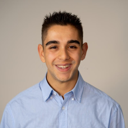

In [31]:
from fastdownload import download_url

#in two lines
path = test_data_path + '/happy.jpg'
download_url(search_images('happy face human', max_images=1)[0], path, show_progress=False)
Image.open(path).to_thumb(128, 128)

Searching for 'sad face human'


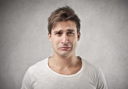

In [32]:
path = test_data_path + '/sad.jpg'
download_url(search_images('sad face human', max_images=1)[0], path, show_progress=False)
Image.open(path).to_thumb(128, 128)

Searching for 'angry face human'


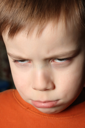

In [33]:
path = test_data_path + '/angry.jpg'
download_url(search_images('angry face human', max_images=1)[0], path, show_progress=False)
Image.open(path).to_thumb(128, 128)

Searching for 'surprised face human'


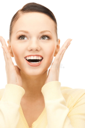

In [34]:
path = test_data_path + '/surprised.jpg'
download_url(search_images('surprised face human', max_images=1)[0], path, show_progress=False)
Image.open(path).to_thumb(128, 128)

In [35]:
searches = 'happy', 'sad', 'angry', 'surprised'
from time import sleep

for search in searches:
    dest = f'{learning_data_path}/{search}'

    download_images(dest, urls = search_images(f'{search} human'))
    sleep(10)
    download_images(dest, urls = search_images(f'{search} human photo'))
    sleep(10)
    download_images(dest, urls = search_images(f'{search} human face'))
    sleep(10)
    download_images(dest, urls = search_images(f'{search} human face photo'))


Searching for 'happy human'
Searching for 'happy human photo'
Searching for 'happy human face'
Searching for 'happy human face photo'
Searching for 'sad human'
Searching for 'sad human photo'
Searching for 'sad human face'
Searching for 'sad human face photo'
Searching for 'angry human'
Searching for 'angry human photo'
Searching for 'angry human face'
Searching for 'angry human face photo'
Searching for 'surprised human'
Searching for 'surprised human photo'
Searching for 'surprised human face'
Searching for 'surprised human face photo'


In [36]:
failed = verify_images(get_image_files(learning_data_path))
failed.map(Path.unlink)
len(failed)

14

In [37]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(learning_data_path, bs=32)

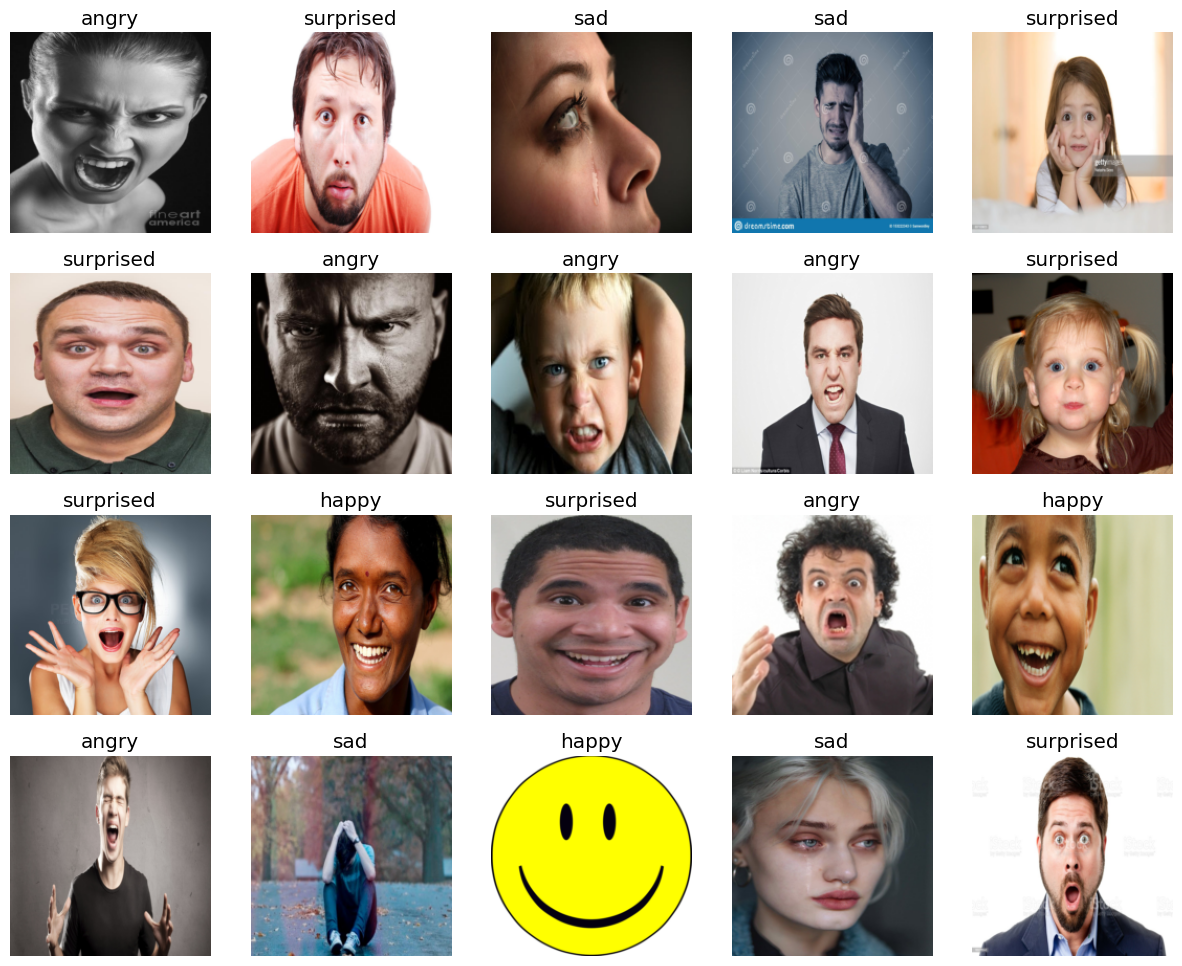

In [38]:
dls.show_batch(max_n=20)

In [39]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

/Users/vojta/Library/Caches/pypoetry/virtualenvs/fast-ai-notebooks-oSgpAbbe-py3.9/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/vojta/Library/Caches/pypoetry/virtualenvs/fast-ai-notebooks-oSgpAbbe-py3.9/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


/Users/vojta/Library/Caches/pypoetry/virtualenvs/fast-ai-notebooks-oSgpAbbe-py3.9/lib/python3.9/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [40]:
emotion,_,probs = learn.predict(PILImage.create(test_data_path + '/sad.jpg'))
print(f"This is a: {emotion}.")
print(f"Probability it's a angry: {probs[0]:.4f}")
print(f"Probability it's a happy: {probs[1]:.4f}")
print(f"Probability it's a sad: {probs[2]:.4f}")
print(f"Probability it's a suprised: {probs[3]:.4f}")

This is a: sad.
Probability it's a angry: 0.0132
Probability it's a happy: 0.0019
Probability it's a sad: 0.9845
Probability it's a suprised: 0.0005


In [41]:
learn.export(model_path + '/emotion.pkl')

In [42]:
#|export
learner = load_learner(model_path + '/emotion.pkl')

In [43]:
#|export
def classify_image(img):
    pred, idx, probs = learner.predict(img)
    return dict(zip(learner.dls.vocab, map(float, probs)))


In [44]:
classify_image(PILImage.create(test_data_path + '/sad.jpg'))

{'angry': 0.013161320239305496,
 'happy': 0.001865934464149177,
 'sad': 0.9845104813575745,
 'surprised': 0.00046226827544160187}

In [ ]:
#|export
import gradio as gr

image = gr.inputs.Image(shape=(192, 192))
label = gr.outputs.Label()
examples = [
    [test_data_path + '/happy.jpg'],
    [test_data_path + '/sad.jpg'],
    [test_data_path + '/angry.jpg'],
    [test_data_path + '/surprised.jpg']
]

intf = gr.Interface(fn=classify_image, inputs=image, outputs=label, examples=examples)
intf.launch(inline=False)

/Users/vojta/Library/Caches/pypoetry/virtualenvs/fast-ai-notebooks-oSgpAbbe-py3.9/lib/python3.9/site-packages/gradio/inputs.py:259: UserWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  warnings.warn(
/Users/vojta/Library/Caches/pypoetry/virtualenvs/fast-ai-notebooks-oSgpAbbe-py3.9/lib/python3.9/site-packages/gradio/deprecation.py:40: UserWarning: `optional` parameter is deprecated, and it has no effect
  warnings.warn(value)
/Users/vojta/Library/Caches/pypoetry/virtualenvs/fast-ai-notebooks-oSgpAbbe-py3.9/lib/python3.9/site-packages/gradio/outputs.py:197: UserWarning: Usage of gradio.outputs is deprecated, and will not be supported in the future, please import your components from gradio.components
  warnings.warn(
/Users/vojta/Library/Caches/pypoetry/virtualenvs/fast-ai-notebooks-oSgpAbbe-py3.9/lib/python3.9/site-packages/gradio/deprecation.py:40: UserWarning: The 'type' parameter has been dep

Running on local URL:  http://127.0.0.1:7861

To create a public link, set `share=True` in `launch()`.


In [46]:
nbdev.export.nb_export('emotion-recognition-notebook.ipynb', './')